## Imports

In [2]:
import nltk
from pathlib import Path
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

### Figure 2a

Which topics are shared the most?
{'Benefits': 3,
 'Births, deaths, marriages and care': 21,
 'Business and self-employed': 300,
 'Childcare and parenting': 6,
 'Citizenship and living in the UK': 6,
 'Coronavirus (COVID-19)': 36,
 'Crime, justice and the law': 21,
 'Driving and transport': 55,
 'Education, training and skills': 28,
 'Environment and countryside': 15,
 'Housing and local services': 10,
 'Money and tax': 36,
 'Passports, travel and living abroad': 3,
 'Visas and immigration': 6,
 'Working, jobs and pensions': 36}
[(' Education and Skills Funding Agency', 'Cabinet Office', 1),
 (' Education and Skills Funding Agency', 'Civil Service Fast Stream', 1),
 (' Education and Skills Funding Agency', 'DWP', 1),
 (' Education and Skills Funding Agency', 'DfE', 1),
 (' Education and Skills Funding Agency', 'Government Equalities Office', 1),
 (' Education and Skills Funding Agency', 'Insolvency Service', 1),
 (' Education and Skills Funding Agency', 'Ministry of Defence', 1),
 (' E

c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


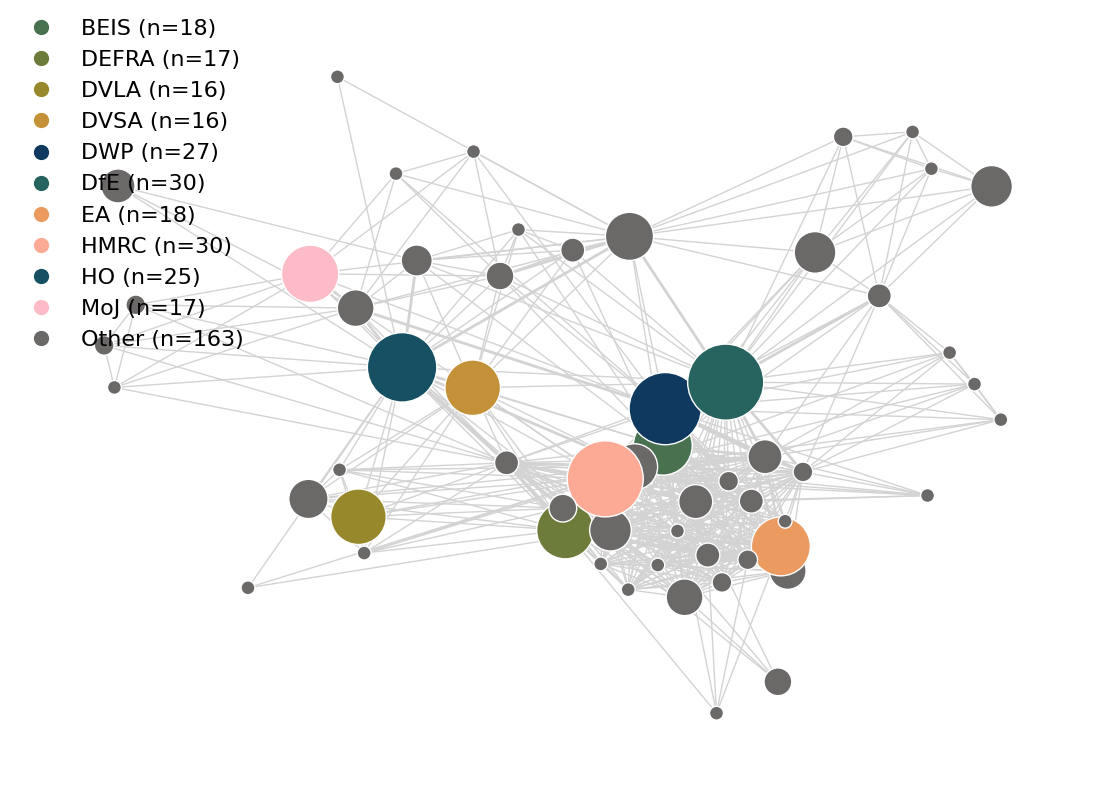

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


def plot_organisation_network(save=False):
    """
    Load and plot organisations network.
    """
    
    # Assuming services_df is your DataFrame
    services_df = pd.read_pickle(Path('../data/processed/dataframes/descriptive-df-w-api-data.pkl'))

    # Abbreviate organisation names
    mapping = {
        'Department for Business, Energy & Industrial Strategy': 'BEIS', 
        'Department for Environment, Food & Rural Affairs': 'DEFRA',
        'Department for Education' : 'DfE',
        'Department for Work and Pensions': 'DWP',
        'Driver and Vehicle Licensing Agency': 'DVLA',
        'Driver and Vehicle Standards Agency': 'DVSA',
        'HM Revenue and Customs': 'HMRC', 
        'Home Office': 'HO',
        'Ministry of Justice': 'MoJ',
        'Environment Agency': 'EA'
    }
    
    services_df.replace(mapping, inplace=True) 
    
    # Task 1: Create a NetworkX graph
    G = nx.Graph()
    
    # Define palette
    PALETTE = [
    '#48714f', '#6d7c3b', '#97882c', '#c49138',
    '#0f395f', '#27635f',
    '#eb9a60', '#fca995', '#165062', '#fdbac7'
    ]

    # Add nodes for organizations
    org_service_count = services_df.groupby('organisation')['service'].nunique().reset_index()
    org_service_count.columns = ['organisation', 'service_count']

    # Create a list to store colors for nodes
    node_colors = []

    # Task 1.1: Assign unique colors to nodes with 15 or more services
    unique_colors = sns.color_palette(PALETTE, n_colors=10)  # Use Set1 colormap
    color_mapping = dict(zip(org_service_count.loc[org_service_count['service_count']>=15].organisation, unique_colors))

    for index, row in org_service_count.iterrows():
        if row['service_count'] >= 15:
            G.add_node(row['organisation'], size=row['service_count'], color=row['service_count'])
            node_colors.append(color_mapping[row['organisation']])  # Use a unique color for nodes with 15 or more services
        else:
            G.add_node(row['organisation'], size=row['service_count'], color=0)  # 0 represents 'Other' nodes
            node_colors.append('#6b6868')  # Color nodes with less than 15 services as #e6e4cc

    # Task 2: Add edges between organizations based on shared topics, edge weight based on the number of shared topics
    # Also keep account of which service topics are most commonly shared
    num_shares = {}
    seen_orgs = [] #keep track so we don't do edges twice
    edges = []
    for org1 in org_service_count['organisation']:
        for org2 in org_service_count['organisation']:
            if org1 != org2 and (org1, org2) not in seen_orgs:
                topics1 = set(services_df[services_df['organisation'] == org1]['topic'])
                topics2 = set(services_df[services_df['organisation'] == org2]['topic'])
                shared_topics = topics1.intersection(topics2)
                if shared_topics:
                    G.add_edge(org1, org2, weight=len(shared_topics))
                    edges.append((org1, org2, len(shared_topics)))
                    
                    #add num share statistics
                    for top in shared_topics:
                        if not top in num_shares:
                            num_shares[top] = 0
                        num_shares[top] += 1

                    #add the reverse of this edge to make sure we don't do it again 
                    seen_orgs.append((org2, org1))

    print('Which topics are shared the most?')
    import pprint
    pprint.pprint(num_shares)

    #edge list
    pprint.pprint(edges)

    # Get node sizes
    node_sizes = [data['size'] * 100 for _, data in G.nodes(data=True)]

    # Get edge weights
    edge_weights = [data['weight'] for _, _, data in G.edges(data=True)]

    # Create a force-directed layout
    pos = nx.spring_layout(G)
    
    # Draw the network diagram
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, linewidths=1, edgecolors='white')
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='lightgrey')

    # No need to draw node labels separately

    # Task 3: Create a custom legend for nodes with 15 or more services and 'Other' nodes
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=12, label=f'{org} (n={count})')
                       for org, count, color in zip(org_service_count['organisation'], org_service_count['service_count'], node_colors)
                       if count >= 15]  # Filter nodes with 15 or more services

    # Add a label for 'Other' nodes
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#6b6868', markersize=12, label='Other (n=163)'))

    # Create legend in the lower left
    plt.legend(handles=legend_elements, borderaxespad=0., loc='upper left', frameon=False, fontsize=16, ncol=1)

    plt.axis('off')

    # Save figure
    if save == True:
        plt.savefig(Path("../reports/figures/fig2a.png"), dpi=300, bbox_inches='tight')
    else:
        plt.show()
        
    
plot_organisation_network(
    save=True
)

**Interpretation**
- There is a central cluster of organisations that offer the most services; this is perhaps where efforts to adopt automation should be concentrated